In [1]:
from s4 import S4D
from dataloaders import init_dataloader
from torch import nn
import torch
import matplotlib.pyplot as plt

CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.
Falling back on slow Cauchy and Vandermonde kernel. Install at least one of pykeops or the CUDA extension for better speed and memory efficiency.


In [2]:
batch_size = 1 
inp_dim = 10 
L = 128 # sequence length

inp = torch.rand(batch_size, L, inp_dim) - 0.5
# inp[0, 1, :] = 1
# inp[0, 50, :] = 1

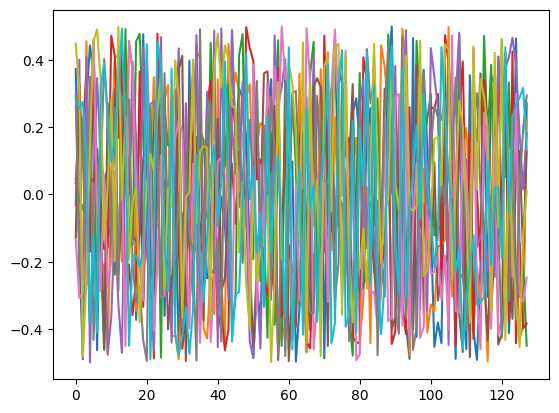

In [3]:
plt.plot(inp[0]);

In [4]:
model_dim = inp_dim 
dropout = 0

# inp_projection = nn.Linear(inp_dim, model_dim, bias=None)


model = S4D(d_model=model_dim,
            d_state=1,
            dropout=dropout,
            transposed=False,
            lr=None,
            is_real=True)



In [5]:
# proj = inp_projection(inp)
out, _ = model(inp)
print(out.shape)

RuntimeError: einsum(): subscript h has size 10 for operand 1 which does not broadcast with previously seen size 5

In [ ]:
model.setup_step()
state = model.default_state(batch_size)
print(state.shape, inp[:, 0, :].shape)

torch.Size([1, 10, 1]) torch.Size([1, 10])


In [ ]:
out_step = torch.zeros_like(out)
for t in range(L-1):
    y, state = model.step(inp[:, t, :], state)
    out_step[0, t] = y

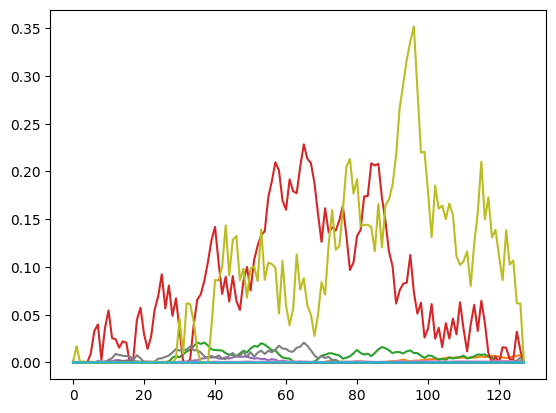

In [ ]:
plt.plot(out_step[0].detach().numpy());

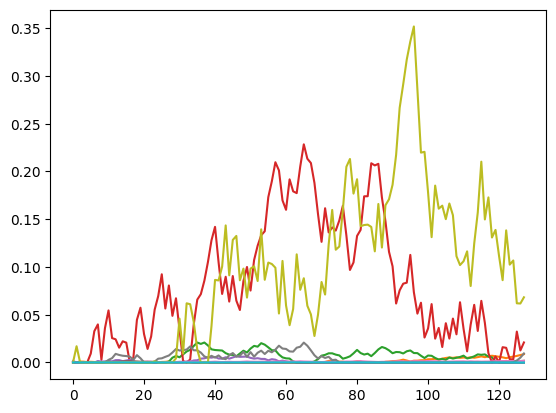

In [ ]:
plt.plot(out[0].detach().numpy());

In [ ]:
last_inp = inp[0, -1] * model.layer.kernel.dB.t()
last_state = state * model.layer.kernel.dA + last_inp.unsqueeze(-1)
print(last_inp.shape, last_state)


torch.Size([1, 10]) tensor([[[-0.0024],
         [-0.0053],
         [ 0.0086],
         [ 0.0081],
         [-0.0029],
         [-0.0024],
         [-0.0049],
         [-0.0254],
         [ 0.0326],
         [-0.0051]]], grad_fn=<AddBackward0>)


In [ ]:
nn.functional.relu(last_state * model.layer.kernel.dC * 2)

tensor([[[0.0000],
         [0.0087],
         [0.0000],
         [0.0210],
         [0.0000],
         [0.0018],
         [0.0017],
         [0.0094],
         [0.0682],
         [0.0000]]], grad_fn=<ReluBackward0>)

In [ ]:
out[0, -1]

tensor([0.0000, 0.0087, 0.0000, 0.0210, 0.0000, 0.0018, 0.0017, 0.0094, 0.0682,
        0.0000], grad_fn=<SelectBackward0>)